#### Setup

In [50]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)
from sentinelhub import SHConfig
config = SHConfig()

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

#### Loading the Data

In [51]:
# One-off dataset creation

with open("Datasets/site_locations.csv") as file:
        locations = pd.read_csv(file,sep=",")

with open("Datasets/bestand_04_11_22.csv") as file:
        bestand = pd.read_csv(file,sep=",")

# # create a column where we map the site abbreviation to the respective bounding box
# locations = locations.dropna()
# bestand["LocationBBox"] = bestand["SITE"]
# bestand["BoundingBox"] = bestand["LocationBBox"].map(dict(zip(locations["Abbreviation"],locations["BoundingBox"])))

# # Calculate the bboxes
resolution = 60
# bbox_object_list = []
# bbox_size_list = []
# for bbox_coords in bestand["BoundingBox"]:
#     bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
#     bbox_size = bbox_to_dimensions(bbox, resolution=resolution)

#     bbox_object_list.append([bbox])
#     bbox_size_list.append(bbox_size)

# bestand["BoundingBoxSize"] = bbox_size_list

# # update the file
# bestand.to_csv("Datasets/bestand_04_11_22.csv")

#### Script Preparation

In [52]:
from typing import Any, Optional, Tuple

def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: Optional[Tuple[float, float]] = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [53]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

#### Downloading a series of images from the same field

In [54]:
import itertools

# downloading timeseries
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 12, 31)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

# modify to accept timeslot, bbox, size and path
def request_all_bands_timed(time_interval,bbox,bbox_size,location_name):
    return SentinelHubRequest(
        data_folder="SatelliteImages/SatelliteImages"+location_name,
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=bbox_size,
        config=config,
    )
# allow the DF to save the response objects
bestand["AllBandsTimed"] = np.nan
bestand["AllBandsTimed"] = bestand["AllBandsTimed"].astype('object')

for row in bestand.itertuples():
    print("Starting row ",row.LocationBBox)
    # create a list of requests
    bbox = BBox(bbox=row.BoundingBox, crs=CRS.WGS84)
    bbox_size = bbox_to_dimensions(bbox, resolution=resolution)
    list_of_requests = [request_all_bands_timed(slot, bbox, bbox_size, row.LocationBBox).get_data(save_data=True) for slot in slots]
    bestand.at[row.Index,"AllBandsTimed"] = list_of_requests

Monthly time windows:

('2019-01-01', '2019-01-29')
('2019-01-29', '2019-02-26')
('2019-02-26', '2019-03-26')
('2019-03-26', '2019-04-23')
('2019-04-23', '2019-05-21')
('2019-05-21', '2019-06-18')
('2019-06-18', '2019-07-16')
('2019-07-16', '2019-08-13')
('2019-08-13', '2019-09-10')
('2019-09-10', '2019-10-08')
('2019-10-08', '2019-11-05')
('2019-11-05', '2019-12-03')
Starting row  Abs
Starting row  Abs
Starting row  Abs
Starting row  Au1
Starting row  Au1
Starting row  Au1
Starting row  Au2
Starting row  Au2
Starting row  Au2
Starting row  Burg1
Starting row  Burg1
Starting row  Burg1
Starting row  Burg2
Starting row  Burg2
Starting row  Burg2
Starting row  Eis
Starting row  Eis
Starting row  Eis
Starting row  Fischa
Starting row  Fischa
Starting row  Fischa
Starting row  Grü
Starting row  Grü
Starting row  Grü
Starting row  Lack1
Starting row  Lack1
Starting row  Lack1
Starting row  Lack2
Starting row  Lack2
Starting row  Lack2
Starting row  Man1
Starting row  Man1
Starting row  Man1

#### Plotting the Band Histograms

In [55]:
ex_1 = bestand.at[2,"AllBandsTimed"]

# move the bands to a nice np-array
stacked_bands = np.stack(ex_1[0])
stacked_bands = np.moveaxis(stacked_bands, 3, 0).squeeze()
stacked_bands.shape

(13, 3, 4)

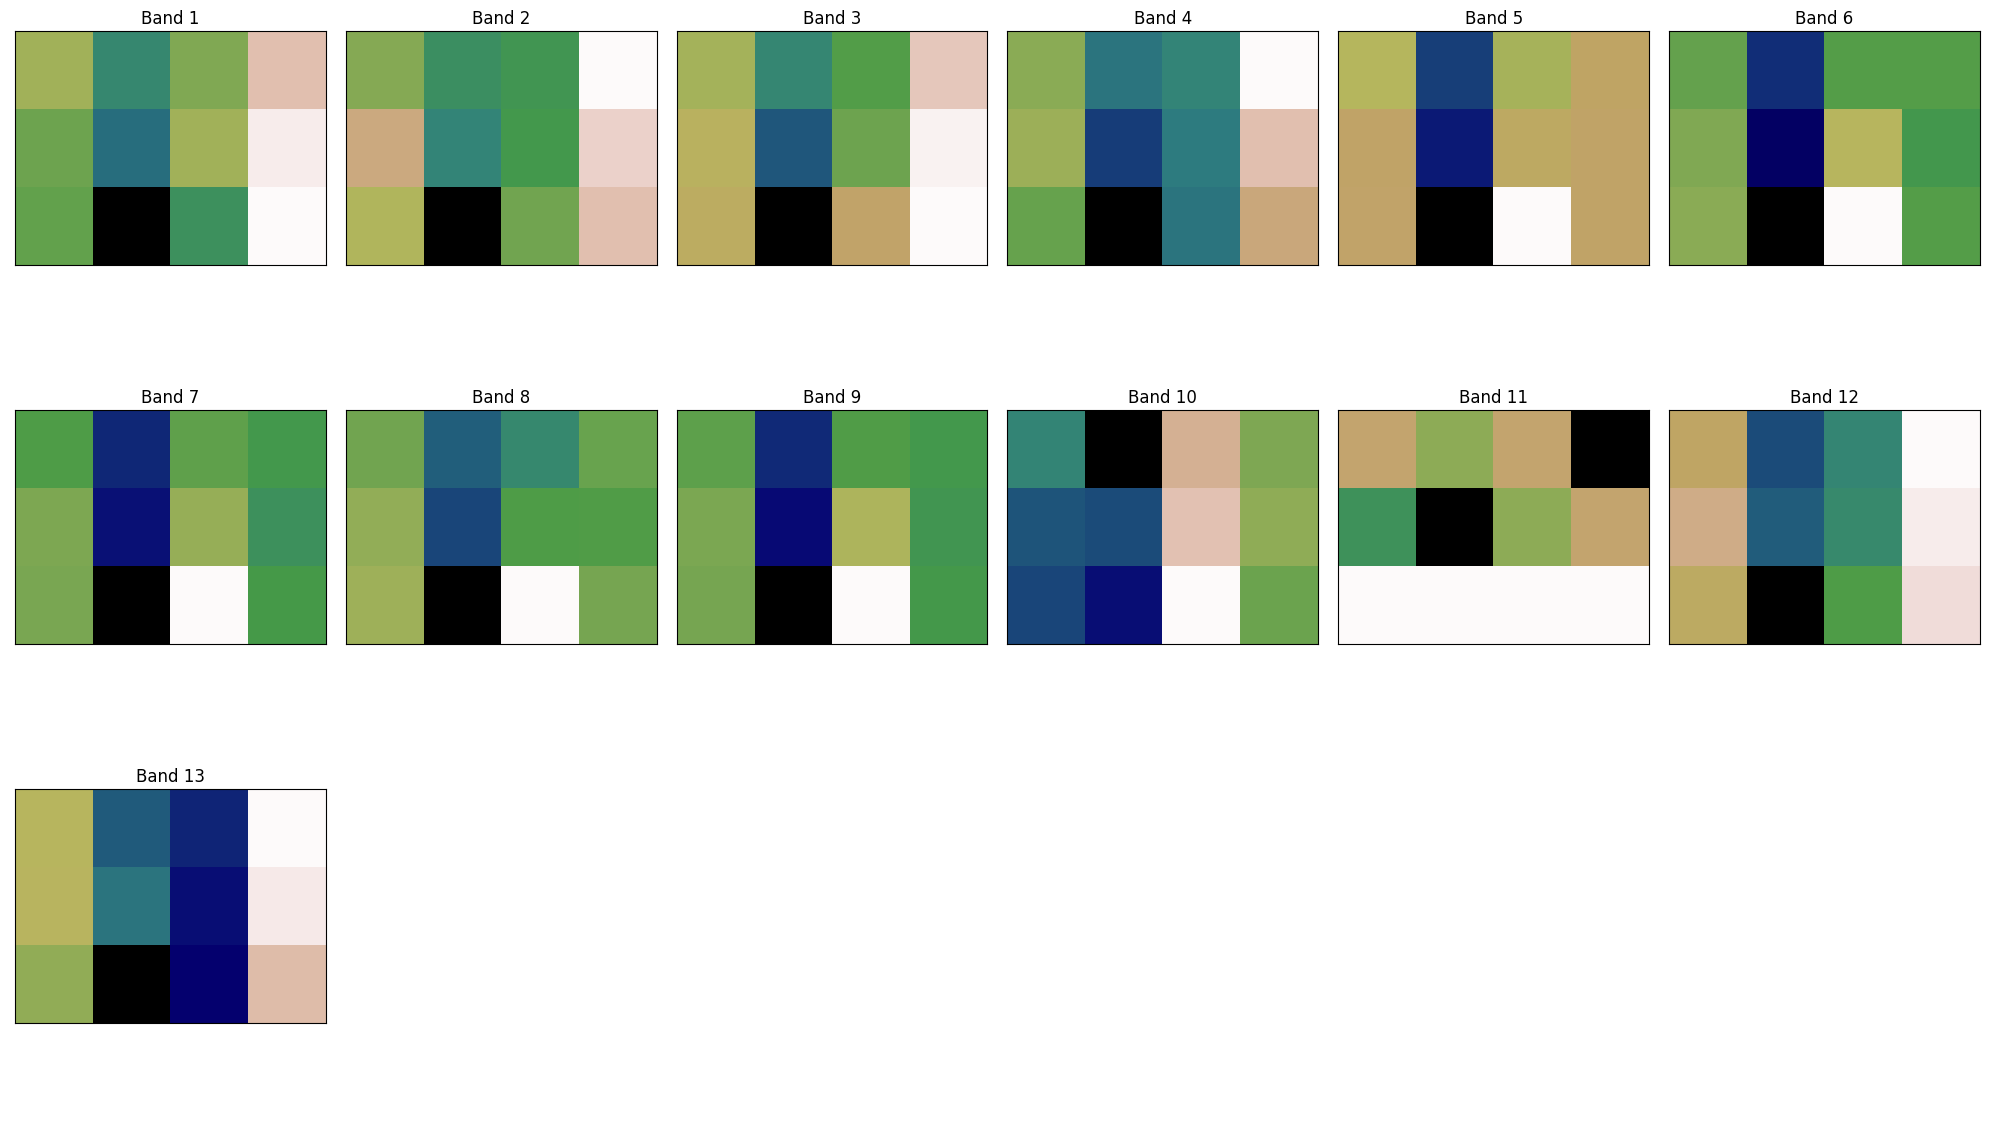

In [56]:
# Plot all bands
ep.plot_bands(stacked_bands, 
              cmap = 'gist_earth', 
              figsize = (20, 12), 
              cols = 6, 
              cbar = False)
plt.show()

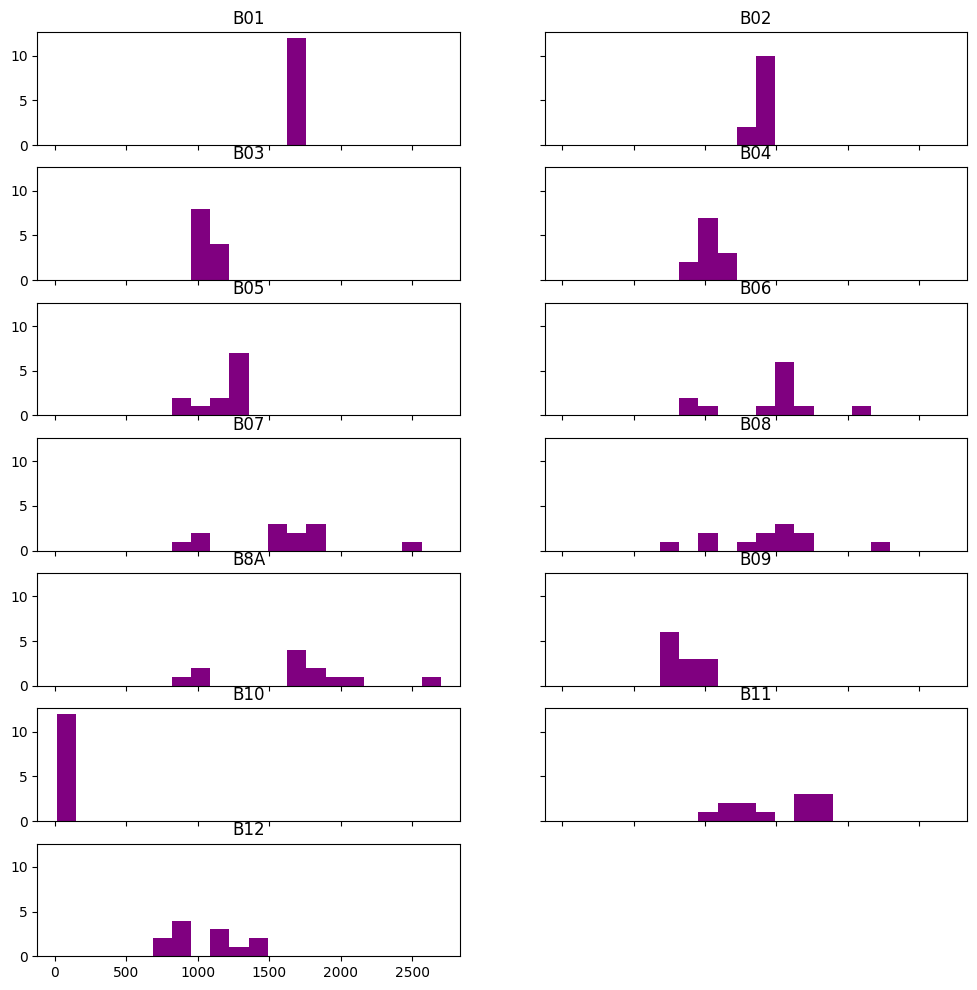

In [57]:
# Create the list of titles for each band. The titles and colors listed
# in this example reflect the order and wavelengths of the Landsat 8 bands
titles = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]

# and a histogram of the spectrums
ep.hist(stacked_bands, title=titles)
plt.show()

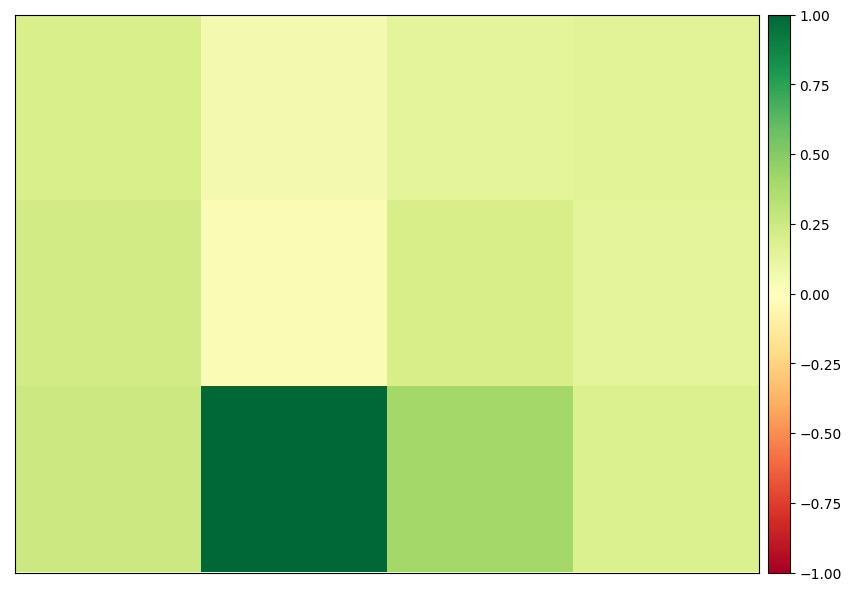

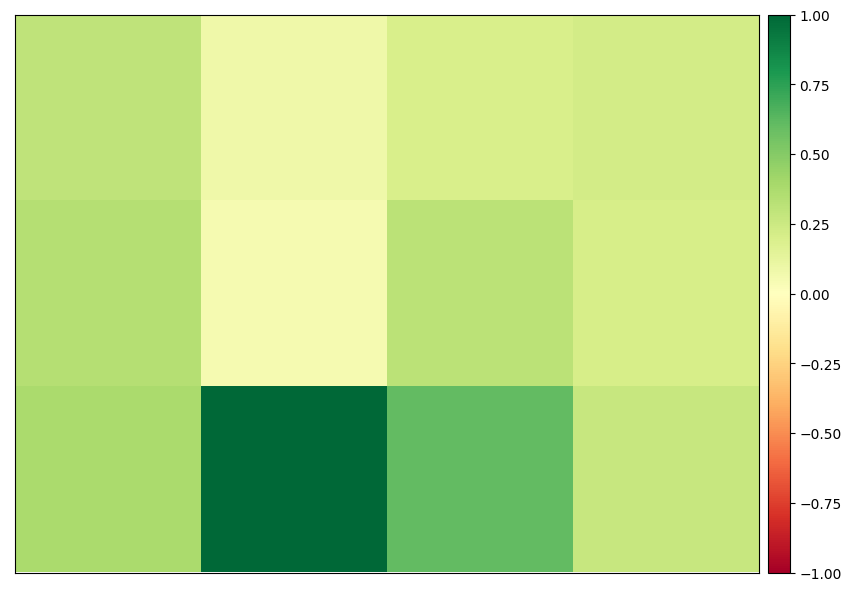

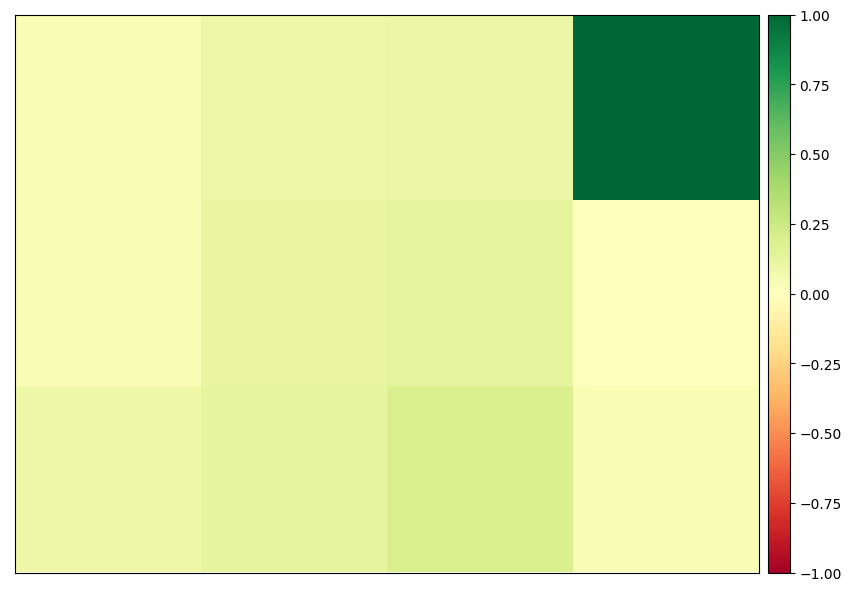

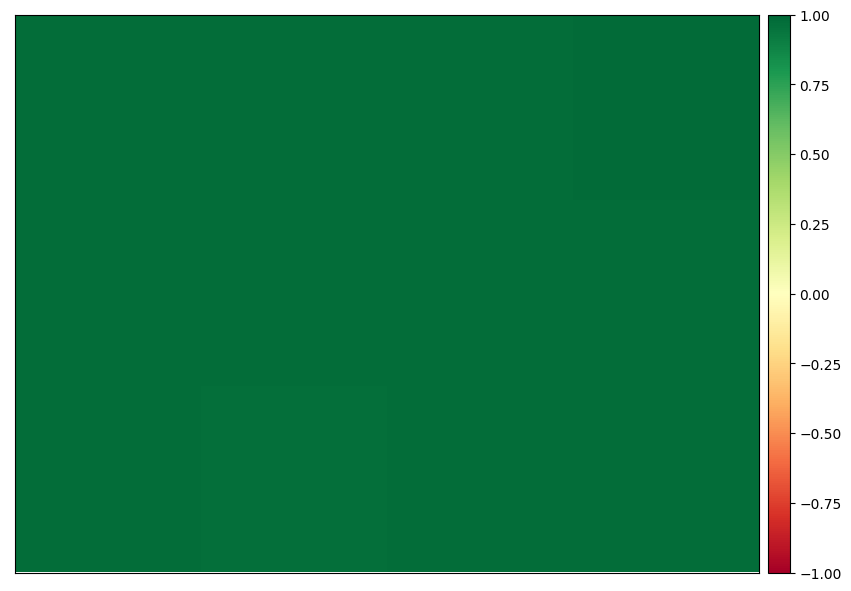

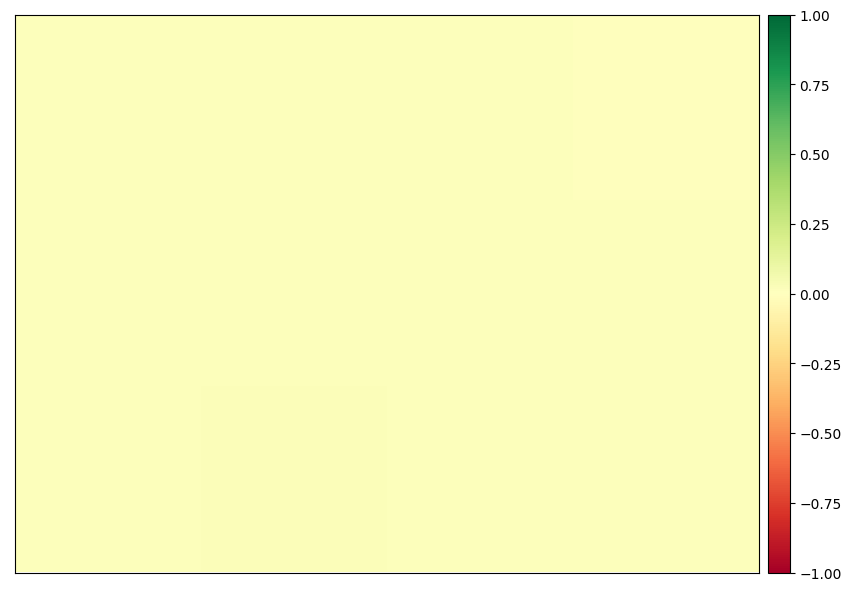

In [58]:
ndvi = es.normalized_diff(stacked_bands[7], stacked_bands[3])

L = 0.5
savi = ((stacked_bands[7] - stacked_bands[3]) / (stacked_bands[7] + stacked_bands[3] + L)) * (1 + L)

vari = (stacked_bands[2] - stacked_bands[3])/ (stacked_bands[2] + stacked_bands[3] - stacked_bands[1])

mndwi = es.normalized_diff(stacked_bands[2], stacked_bands[10])

cmr = np.divide(stacked_bands[10], stacked_bands[11])

indices = [ndvi,savi,vari,mndwi,cmr]

for index in indices:
    ep.plot_bands(index, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

#### Computing indices for all areas

In [59]:
h_max = 1.7
h_min = 0.7
L = 0.5
no_data = -9999

pixel_per_area_list = []
# for each area
for row in bestand.itertuples():
    # get the timed samples for each pixel
    area_samples = np.asarray(row.AllBandsTimed)
    # remove that one useless dimension
    area_samples = area_samples[:,0,:,:,:]
    # reshape (time_samples, x, y, bands) to (time_samples, x*y, bands)
    area_x = area_samples.shape[1]
    area_y = area_samples.shape[2]
    area_samples = area_samples.reshape(area_samples.shape[0],area_samples.shape[1]*area_samples.shape[2],area_samples.shape[3])
    # swap axes to have (x*y, time_samples, bands) to iterate over pixels
    area_samples = area_samples.swapaxes(0,1)
    
    pixel_list = []
    # iterate through the (x*y) pixels
    for pixel in area_samples:

            updated_pixel = pixel

            # compute all the indices
            ndvi = es.normalized_diff(pixel[:,7], pixel[:,3])
            savi = ((pixel[:,7] - pixel[:,3]) / (pixel[:,7] + pixel[:,3] + L)) * (1 + L)
            vari = (pixel[:,2] - pixel[:,3])/ (pixel[:,2] + pixel[:,3] - pixel[:,1])
            mndwi = es.normalized_diff(pixel[:,2], pixel[:,10])
            cmr = np.divide(pixel[:,10], pixel[:,11])

            # get the min and max_pv index through the time_samples
            pv = ((pixel[:,7]-pixel[:,3])/(pixel[:,7]+pixel[:,3]))+ ((pixel[:,7]-pixel[:,1])/(pixel[:,7]+pixel[:,1]))
            pv_max = max(pv)
            pv_min = min(pv)

            # leave this pixel enabled if pv_max_min greater/smaller, else set the mask band to 0
            bare_soil_pixel = 1 if (pv_max>h_max and pv_min<h_min) else 0
            mask_band = [bare_soil_pixel for i in range(pixel.shape[0])]

            #add the computed indices as bands to each pixel
            indices = np.asarray([ndvi,savi,vari,mndwi,cmr, pv, mask_band])
            updated_pixel = np.column_stack((pixel,indices.T))

            # compute the soil reflectance composite for all bands if bare soil pixel
            if bare_soil_pixel and pv_min<h_min:
                # average reflectance along all bands
                soil_reflectance_composite = np.average(updated_pixel[:,:12],axis=0)

                # add the averages as new row to the array
                new_row = [no_data for i in range(updated_pixel.shape[1])]
                new_row[:12] = soil_reflectance_composite
            # else just add a no-data row
            else:
                new_row = [no_data for i in range(updated_pixel.shape[1])]

            updated_pixel = np.row_stack((updated_pixel,new_row))

            #add this pixel with indices to the pixel list
            pixel_list.append(updated_pixel)
    
    # add this set of pixels with indices per area to the list
    pixel_per_area_list.append(np.asarray(pixel_list))

# and set it as new column
bestand["BandsWithIndices"] = np.asarray(pixel_per_area_list)

/home/carlo/GitHub/AISoilIndicator/ai_soil_env/lib/python3.10/site-packages/earthpy/spatial.py:105: RuntimeWarning: invalid value encountered in divide
  n_diff = (b1 - b2) / (b1 + b2)
/tmp/ipykernel_7054/2857317639.py:34: RuntimeWarning: invalid value encountered in divide
  pv = ((pixel[:,7]-pixel[:,3])/(pixel[:,7]+pixel[:,3]))+ ((pixel[:,7]-pixel[:,1])/(pixel[:,7]+pixel[:,1]))
/tmp/ipykernel_7054/2857317639.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bestand["BandsWithIndices"] = np.asarray(pixel_per_area_list)


In [60]:
ex_1 = bestand.at[20,"BandsWithIndices"]

In [61]:
ex_1.shape

(48, 13, 20)

#### Transform individual pixel/band values to columns with average values

In [62]:
location_band_average_placeholder = []

for row in bestand.itertuples():
    pixel_list = row.BandsWithIndices
    pixel_band_average = []
    for pixel in pixel_list:
        #take the average except the SRC (row) and mask band (column)
        time_band_average = np.average(pixel[:-1, :-1],axis=0)
        pixel_band_average.append(time_band_average)
    # get the average of each band over all pixels
    location_band_average = np.average(pixel_band_average,axis=0)
    # and map the values to this row
    location_band_average_placeholder.append(location_band_average)

In [65]:
# create a tempdf and concat it to bestand
temp_df = pd.DataFrame(location_band_average_placeholder, columns=["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12","ndvi","savi","vari","mndwi","cmr", "pv"])
bestand_with_band_averages = pd.concat([bestand,temp_df],axis=1)

In [66]:
# # update the file
bestand_with_band_averages.to_csv("Datasets/bestand_08_11_22.csv")

##### Create a Random Forest to see if we can (better) predict SOC

    # 1. Create DF with a large number of satellite samples per area
    # 2. Compute the pv index for each sample
    # 3. Generate pv_max, pv_min for each pixel -> this is on a per-pixel scale whether it is bare soil
    # 4. Mask areas based on whether the pv_ value is greater/smaller than the threshold h_ -> again, for each pixel/image per timestep
    # h_max is used to find fields

    # 5. take intersection of both masks
    #soil_mask = intersection(soil_mask_h_max, soil_mask_h_min)

    # Next steps: apply index computation to each pixel - build the pv index for each pixel, and apply a mask where it doesnt reach the h_max thresholds.
    # then, we have the bare soil pixels and can compute stuff with them (hopefully)

SRC = average reflectance where SM=1 and pvmin<hmin

-> need to create masks?
-> finalize with soil reflectances?
-> select the indices they used and repeat prediction

Their bands: green (2), red(3), NIR (4), SCMAPI, NDSI

In [68]:
import pandas as pd
from pandas.api.types import is_string_dtype

import numpy as np
from math import sqrt

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

# Statistics
from pingouin import ancova
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# PCA
from sklearn.decomposition import PCA

# ML
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

#### Load and Split Vars

In [70]:
bestand_with_band_averages.columns

Index(['Unnamed: 0', 'Unnamed: 0.2', 'SITE', 'SYSTEM', 'DEPT', 'Clay', 'Silt',
       'Sand', 'pH', 'Aggregate Stability', 'Bulk Density', 'Organic Carbon',
       'Dissolved Org. Carbon', 'Carbon-to-Nitrogen', 'Ergosterol',
       'Microbial Carbon', 'Microbial Nitrogren', 'Microbial Phosphorus',
       'Manosamine', 'Muramic Acid', 'Glucosamine', 'Sum Aminosugars', 'LAP',
       'NAG', 'GLU', 'XYL', 'CEL', 'PHO', 'BoundingBox', 'LocationBBox',
       'BoundingBoxObjects', 'BoundingBoxSize', 'AllBandsTimed',
       'BandsWithIndices', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07',
       'B08', 'B8A', 'B09', 'B10', 'B11', 'B12', 'ndvi', 'savi', 'vari',
       'mndwi', 'cmr', 'pv'],
      dtype='object')

In [75]:
# The target variable
target = "Organic Carbon"

# Drop autocorrelated and other unrelated columns
bestand = bestand_with_band_averages.drop(['Unnamed: 0', 'Unnamed: 0.2','BoundingBox', 'LocationBBox','BoundingBoxObjects', 'BoundingBoxSize', 'AllBandsTimed','BandsWithIndices', ], axis=1)

# drop empty rows
bestand.dropna(axis=0,how='any',inplace=True)

def split_data(bestand):
    # Categories and explanatory vars split
    Categories = bestand.iloc[:,:3]
    Explanatory_Variables = bestand.iloc[:,3:]

    # Move into X,y
    X = Explanatory_Variables.drop(target, axis=1)
    y = Explanatory_Variables[target]

    # Train, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return Categories, Explanatory_Variables, X, y, X_train, X_test, y_train, y_test

Categories, Explanatory_Variables, X, y, X_train, X_test, y_train, y_test = split_data(bestand)

<AxesSubplot:>

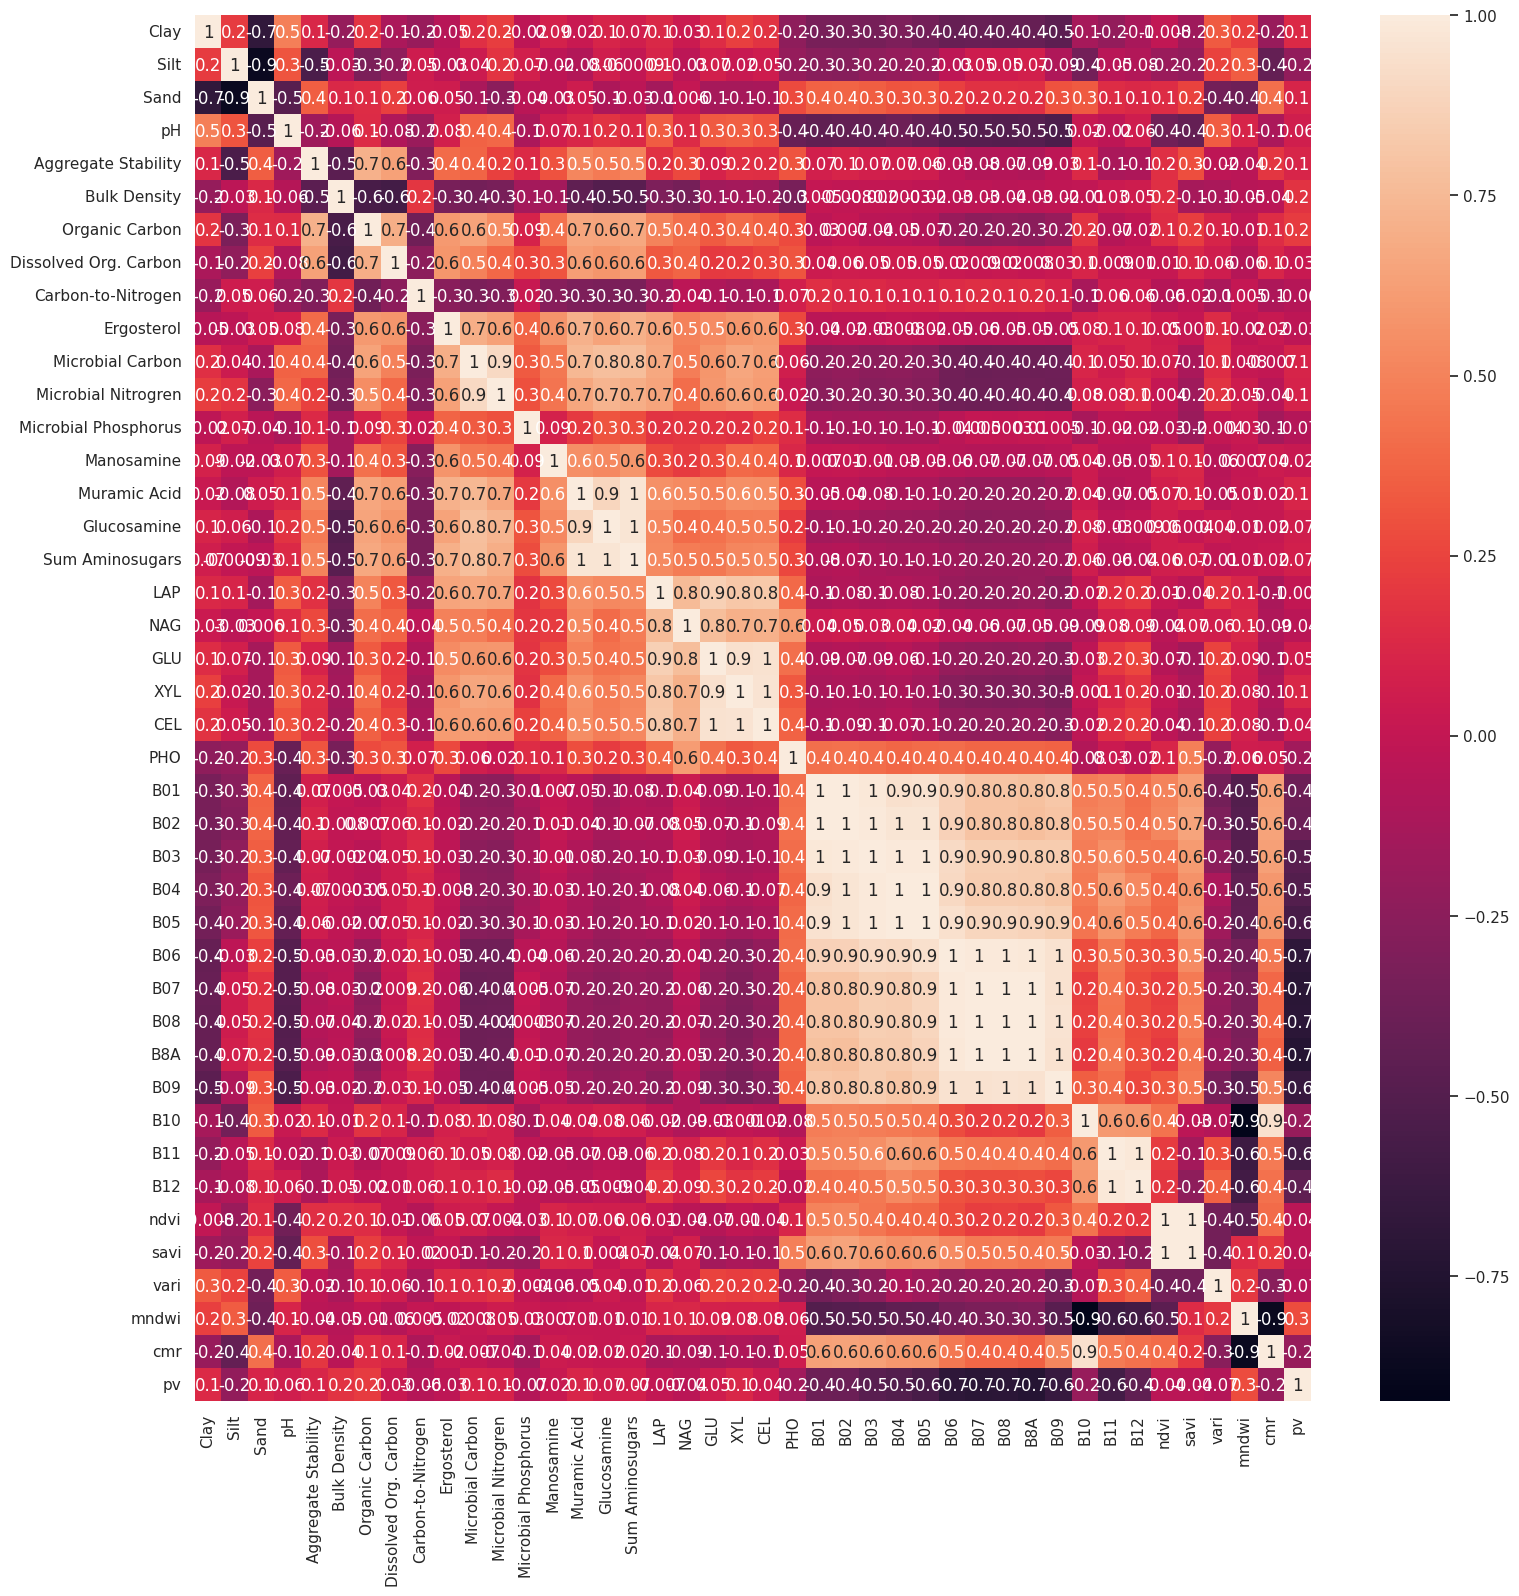

In [73]:
sns.set(rc={'figure.figsize':(18,18)})
correlations = Explanatory_Variables.corr()
sns.heatmap(correlations, annot=True, fmt='.1g')

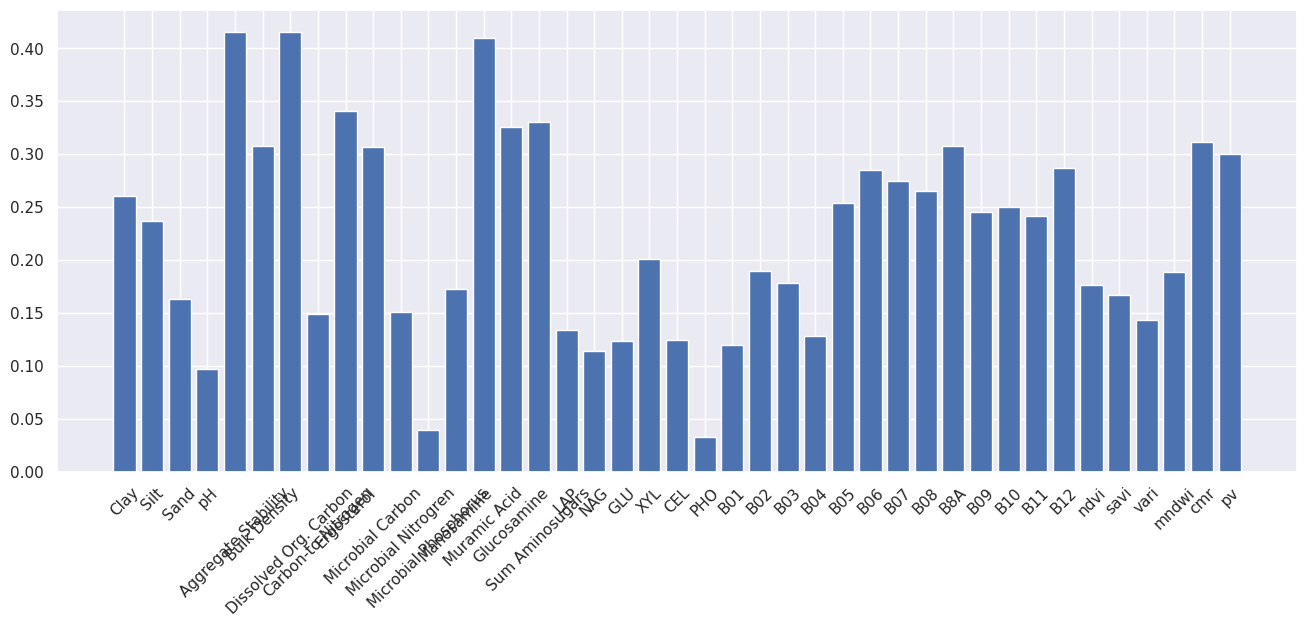

,Aggregate Stability,Bulk Density,Dissolved Org. Carbon,Ergosterol,Microbial Carbon,Muramic Acid,Glucosamine,Sum Aminosugars,B8A,cmr
0,0.549152,-0.243647,0.139548,0.435019,1.354085,1.480324,0.504609,1.095478,2424.576389,0.013689
1,1.231605,-1.048921,1.435819,1.889805,1.749813,2.985442,1.773790,2.436231,2424.576389,0.013689
2,0.467364,0.995236,-0.993718,-0.074618,-0.269388,0.293393,-0.226865,0.082079,2424.576389,0.013689
3,0.257104,0.251906,0.664681,-0.182266,0.631388,1.117399,0.131703,0.615394,2130.236111,0.010348
4,1.479043,-0.491424,2.698259,1.948741,0.952046,2.826601,1.008892,1.870078,2130.236111,0.010348


In [76]:
sns.set(rc={'figure.figsize':(16,6)})

# Selekt the k best features
X_fs = SelectKBest(mutual_info_regression, k=10).fit(X,y)
plt.bar([X.columns[i] for i in range(len(X_fs.scores_))], X_fs.scores_)
plt.xticks(rotation = 45)
plt.show()

# Get columns to keep and create new dataframe with those only
cols = X_fs.get_support(indices=True)
X_feature_reduced = X.iloc[:,cols]

# Redo the split with reduced x
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_feature_reduced, y, test_size=0.3, random_state=42)

X_feature_reduced.head()

#### Automatic feature-selected random forest

In [77]:
model = RandomForestRegressor()
model.fit(X_train_reduced, y_train)
y_pred = model.predict(X_test_reduced)

display("Feature Importance: ",pd.DataFrame({'Variable':X_feature_reduced.columns,'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

mse = mean_squared_error(y_test, model.predict(X_test_reduced))
mae = mean_absolute_error(y_test, model.predict(X_test_reduced))
rmspe = (np.sqrt(np.mean(np.square((y_test - model.predict(X_test_reduced)) / y_test)))) * 100
mape = mean_absolute_percentage_error(y_test, model.predict(X_test_reduced))

print("\nmse = ",mse,"\nmae = ",mae,"\nrmse = ", sqrt(mse),"\nrmspe = ",rmspe, "\nmape = ",round(mape * 100, 2))

'Feature Importance: '

,Variable,Importance
0,Aggregate Stability,0.304798
6,Glucosamine,0.180073
2,Dissolved Org. Carbon,0.143158
5,Muramic Acid,0.109021
1,Bulk Density,0.095725
4,Microbial Carbon,0.048313
7,Sum Aminosugars,0.043716
8,B8A,0.036979
9,cmr,0.019651
3,Ergosterol,0.018566



mse =  0.3072963542581594 
mae =  0.3558412908895058 
rmse =  0.5543431737273937 
rmspe =  161.58741505922853 
mape =  90.21


#### SCMAP feature-selected random forest

In [80]:
# Get columns to keep and create new dataframe with those only
cols = ["Microbial Carbon","cmr","B08","pv","Aggregate Stability"]
X_feature_reduced = X.loc[:,cols]

# Redo the split with reduced x
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_feature_reduced, y, test_size=0.3, random_state=42)

model = RandomForestRegressor()
model.fit(X_train_reduced, y_train)
y_pred = model.predict(X_test_reduced)

display("Feature Importance: ",pd.DataFrame({'Variable':X_feature_reduced.columns,'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

mse = mean_squared_error(y_test, model.predict(X_test_reduced))
mae = mean_absolute_error(y_test, model.predict(X_test_reduced))
rmspe = (np.sqrt(np.mean(np.square((y_test - model.predict(X_test_reduced)) / y_test)))) * 100
mape = mean_absolute_percentage_error(y_test, model.predict(X_test_reduced))

print("\nmse = ",mse,"\nmae = ",mae,"\nrmse = ", sqrt(mse),"\nrmspe = ",rmspe, "\nmape = ",round(mape * 100, 2))


'Feature Importance: '

,Variable,Importance
4,Aggregate Stability,0.595646
0,Microbial Carbon,0.260212
2,B08,0.058776
1,cmr,0.045993
3,pv,0.039374



mse =  0.27215329884722994 
mae =  0.36571682554098456 
rmse =  0.5216831402750428 
rmspe =  273.37635989276424 
mape =  120.7
